<a href="https://colab.research.google.com/github/Zewtta/pme425_deeplearning_energyoptimization/blob/main/Otimiza%C3%A7%C3%A3o_de_energia_Neural_Network_Plant_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Matrizes de experimento**

## Import bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import itertools
from datetime import datetime
from pathlib import Path

## Cria matriz de experimentos

In [ ]:
# ==== 1ª etapa: Interpola os dados para criar a matriz experimental ====

def parse_start_end_step(s):
    a, b, c = [float(x.strip()) for x in s.split(",")]
    count = int(round((b - a) / c)) + 1
    levels = [a + i*c for i in range(count)]
    levels = [round(x, 6) for x in levels]
    return levels

def expand_factorial(ref_df):
    cols = []
    levels_list = []
    for _, row in ref_df.iterrows():
        col = row["parameter"]
        rng = row["startendstep"]
        levels = parse_start_end_step(rng)
        cols.append(col)
        levels_list.append(levels)
    prod = list(itertools.product(*levels_list))
    exp_df = pd.DataFrame(prod, columns=cols)

    # Adiciona colunas fixas
    exp_df.insert(0, "Name", [f"run_{i+1}" for i in range(len(exp_df))])
    exp_df.insert(1, "Action", True)

    return exp_df

# Exemplo de referência
ref = pd.DataFrame({
    "parameter": [
        "On_Off_Station",
        "Intervalo"
    ],
    "startendstep": [
        "0, 1,1",
        "1, 1000, 1"
    ]
})

# Expande experimentos
experiments_df = expand_factorial(ref)

# ==== 2ª etapa: derivar Start/Stop/Duration e calcular Setup ====

START_FIXO_MIN   = 60     # Start = 60
TG_AQUECIMENTO   = 6.0334    # h  [°C/min]
TG_RESFRIAMENTO  = 0.4734    # c  [°C/min]
TEMP_TRABALHO    = 200.0     # Tw [°C]
TEMP_AMBIENTE    = 27.5      # Ta [°C]

# Derivados do Intervalo
experiments_df["Start"]    = START_FIXO_MIN
experiments_df["Duration"] = experiments_df["Intervalo"].astype(float)
experiments_df["Stop"]     = experiments_df["Start"] + experiments_df["Duration"]

def add_setup_from_interval_inplace(df,
                                    col_intervalo='Intervalo',
                                    col_onoff='On_Off_Station',
                                    col_out='Setup_min',
                                    Tw=TEMP_TRABALHO,
                                    Ta=TEMP_AMBIENTE,
                                    h=TG_AQUECIMENTO,
                                    c=TG_RESFRIAMENTO):

    if col_intervalo not in df.columns:
        raise ValueError(f"Coluna '{col_intervalo}' não encontrada.")
    if col_onoff not in df.columns:
        df[col_onoff] = 1  # 1 = desliga/religa; 0 = mantém ligada

    d  = df[col_intervalo].astype(float).to_numpy()   # pausa em MINUTOS (relativa)
    on = df[col_onoff].astype(int).to_numpy()

    # tempos característicos (min)
    t_amb   = (Tw - Ta) / c                # até ambiente
    t_cross = (h * d) / (h + c)            # interseção (relativa)

    # setup ótimo (min)
    setup = np.where(t_cross <= t_amb, d - t_cross, (Tw - Ta)/h)

    # se mantiver ligada, setup = 0
    setup = np.where(on == 0, 0.0, setup)

    df[col_out] = setup
    return df

add_setup_from_interval_inplace(experiments_df)

# ==== 3ª etapa: converter colunas de minutos para segundos ====

def convert_min_to_sec(df, cols_min):
    for col in cols_min:
        if col in df.columns:
            df[col] = df[col] * 60
        else:
            raise ValueError(f"Coluna '{col}' não encontrada no DataFrame.")
    return df

# Lista de colunas em minutos que queremos converter
colunas_em_minutos = ["Intervalo", "Start", "Duration", "Stop", "Setup_min"]

# Aplica conversão
convert_min_to_sec(experiments_df, colunas_em_minutos)



,Name,Action,On_Off_Station,Intervalo,Start,Duration,Stop,Setup_min
0,run_1,True,0.0,60.0,3600,60.0,3660.0,0.000000
1,run_2,True,0.0,120.0,3600,120.0,3720.0,0.000000
2,run_3,True,0.0,180.0,3600,180.0,3780.0,0.000000
3,run_4,True,0.0,240.0,3600,240.0,3840.0,0.000000
4,run_5,True,0.0,300.0,3600,300.0,3900.0,0.000000
...,...,...,...,...,...,...,...,...
1995,run_1996,True,1.0,59760.0,3600,59760.0,63360.0,1715.450658
1996,run_1997,True,1.0,59820.0,3600,59820.0,63420.0,1715.450658
1997,run_1998,True,1.0,59880.0,3600,59880.0,63480.0,1715.450658
1998,run_1999,True,1.0,59940.0,3600,59940.0,63540.0,1715.450658


## Salva a matriz de experimentos criada

In [ ]:
# Define timestamp
timestamp = datetime.now().strftime("%d.%m.%Y.%H.%M")

# Caminho base
base_path = "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Bases de dados de experimentos para simulação/Projetos Python para base de dados/"

# Nome do arquivo
File_Name = "define_experiment"

# Título do experimento
experiment_title = "Energy"

# Adiciona timestamp no nome do arquivo
experiments_path = f"{base_path}{File_Name}.{experiment_title}.{timestamp}.xlsx"

# Salva
experiments_df.to_excel(experiments_path, index=False)

print(f"Arquivo salvo em: {experiments_path}")

Arquivo salvo em: /content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Bases de dados de experimentos para simulação/Projetos Python para base de dados/define_experiment.Energy.27.08.2025.01.19.xlsx


In [ ]:
experiments_df.iloc[864:1000]

,Name,Action,On_Off_Station,Intervalo,Start,Duration,Stop,Setup_min
864,run_865,True,0.0,51900.0,3600,51900.0,55500.0,0.0
865,run_866,True,0.0,51960.0,3600,51960.0,55560.0,0.0
866,run_867,True,0.0,52020.0,3600,52020.0,55620.0,0.0
867,run_868,True,0.0,52080.0,3600,52080.0,55680.0,0.0
868,run_869,True,0.0,52140.0,3600,52140.0,55740.0,0.0
...,...,...,...,...,...,...,...,...
995,run_996,True,0.0,59760.0,3600,59760.0,63360.0,0.0
996,run_997,True,0.0,59820.0,3600,59820.0,63420.0,0.0
997,run_998,True,0.0,59880.0,3600,59880.0,63480.0,0.0
998,run_999,True,0.0,59940.0,3600,59940.0,63540.0,0.0


## Cria input values para experiment manager

In [ ]:
# ==== 4ª célula: tabela para Input Values do Experiment Manager ====

# pega as colunas exatamente como estão na matriz
cols = [c for c in experiments_df.columns if c not in ("Name", "Action")]

# monta a tabelinha pedida
input_map_df = pd.DataFrame({
    "Input Values": ["" for _ in cols],  # vazio (preenche no Plant)
    "Description": cols
})

# mostra preview no notebook
display(input_map_df)

# 4) salva como xlsx no mesmo path base
ts = datetime.now().strftime("%d.%m.%Y.%H.%M")

out_path = f"{base_path}Input_Values_Energy.{ts}.xlsx"

input_map_df.to_excel(out_path, index=False)

print(f"Tabela de Input Values salva em: {out_path}")


,Input Values,Description
0,,On_Off_Station
1,,Intervalo
2,,Start
3,,Duration
4,,Stop
5,,Setup_min


Tabela de Input Values salva em: /content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Bases de dados de experimentos para simulação/Projetos Python para base de dados/Input_Values_Energy.25.08.2025.03.43.xlsx


# **MLP - Algoritmo final de otimização de processo**

##MLP - Big Data Settings

###MLP - Data augmentation: Otimização de dataset para redução de overfitting com método linear proporcional percentual

In [ ]:
import pandas as pd
import numpy as np

# Carregar base
df = pd.read_excel(
    "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados simulação Energy.xlsx"
).rename(columns={
    "On_Off_Station": "state",
    "Total Energia Consumida": "E_total_kWh"
})

# tempo total da simulação (12h em segundos)
SIM_TIME_S = 12 * 3600

# Função para criar variações com ruído
def expandir_registro(row, n_variacoes=9, tol_tempo=0, maior_tol_perc=0.2, menor_tol_perc=0.05):
    registros = []

    for _ in range(n_variacoes):
        # variação no intervalo (±5 min = 300s)
        intervalo_var = row["Intervalo"] + np.random.uniform(-tol_tempo, tol_tempo)
        intervalo_var = max(0, intervalo_var)  # não deixar negativo

        # variação percentual para setup (mesma % p/ tempo e energia setup)
        perc_setup = 1 + np.random.uniform(-menor_tol_perc, maior_tol_perc)
        setup_min_var     = row["Setup_min"] * perc_setup
        energia_setup_var = row["Energia Setup Consumida"] * perc_setup

        # variação percentual independente para standby
        perc_standby = 1 + np.random.uniform(-menor_tol_perc, maior_tol_perc)
        energia_standby_var = row["Energia Standby Consumida"] * perc_standby

        # tempo de working recalculado
        work_time_s = SIM_TIME_S - intervalo_var - setup_min_var - energia_standby_var
        work_time_s = min(SIM_TIME_S, work_time_s)

        # energia de working com ruído ±20% (tolerância real)
        perc_working = 1 + np.random.uniform(-menor_tol_perc, maior_tol_perc)
        energia_working_var = ((1.08/3600)*work_time_s) * perc_working   # base 1.08 kWh

        # energia total
        e_total_var = energia_setup_var + energia_standby_var + energia_working_var

        # montar registro
        new_row = row.copy()
        new_row["Intervalo"] = intervalo_var
        new_row["Setup_min"] = setup_min_var
        new_row["Energia Setup Consumida"] = energia_setup_var
        new_row["Energia Standby Consumida"] = energia_standby_var
        new_row["work_time_s"] = work_time_s
        new_row["Energia Working Consumida"] = energia_working_var
        new_row["E_total_kWh"] = e_total_var

        registros.append(new_row)

    return registros

# Expandir dataset
augmented = []
for _, row in df.iterrows():
    augmented.append(row)  # manter original
    augmented.extend(expandir_registro(row))

df_aug = pd.DataFrame(augmented).reset_index(drop=True)

print("Shape original:", df.shape)
print("Shape aumentado:", df_aug.shape)

# Aplica df_aug em df para treinar o modelo
df_origin = df
df_origin["Energia_intervalo"] = df_origin["Energia Setup Consumida"] + df_origin["Energia Standby Consumida"]

df = df_aug




Shape original: (2000, 11)
Shape aumentado: (20000, 12)


###MLP - Data augmentation: Otimização de dataset para redução de overfitting usando ruído Gaussiano

In [ ]:
import pandas as pd
import numpy as np

# Carregar base
df = pd.read_excel(
    "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados simulação Energy.xlsx"
).rename(columns={
    "On_Off_Station": "state",
    "Total Energia Consumida": "E_total_kWh"
})

# tempo total da simulação (12h em segundos)
SIM_TIME_S = 24 * 3600

# Função para criar variações com ruído Gaussiano
def expandir_registro_gauss(row, n_variacoes=9, tol_tempo=0, sigma=0.1):
    registros = []

    for _ in range(n_variacoes):
        # variação no intervalo (± tol_tempo segundos)
        intervalo_var = row["Intervalo"] + np.random.normal(0, tol_tempo)
        intervalo_var = max(0, intervalo_var)  # não deixar negativo

        # variação percentual Gaussiana para setup
        perc_setup = 1 + np.random.normal(0, sigma)
        setup_min_var     = row["Setup_min"] * perc_setup
        energia_setup_var = row["Energia Setup Consumida"] * perc_setup

        # variação percentual Gaussiana para standby
        perc_standby = 1 + np.random.normal(0, sigma)
        energia_standby_var = row["Energia Standby Consumida"] * perc_standby

        # tempo de working recalculado
        work_time_s = SIM_TIME_S - intervalo_var - setup_min_var
        work_time_s = max(0, min(SIM_TIME_S, work_time_s))

        # energia de working com ruído Gaussiano
        perc_working = 1 + np.random.normal(0, sigma)
        energia_working_var = row["Energia Working Consumida"] * perc_working   # base 1.08 kWh

        # energia total
        e_total_var = energia_setup_var + energia_standby_var + energia_working_var

        # montar registro
        new_row = row.copy()
        new_row["Intervalo"] = intervalo_var
        new_row["Setup_min"] = setup_min_var
        new_row["Energia Setup Consumida"] = energia_setup_var
        new_row["Energia Standby Consumida"] = energia_standby_var
        new_row["work_time_s"] = work_time_s
        new_row["Energia Working Consumida"] = energia_working_var
        new_row["E_total_kWh"] = e_total_var

        registros.append(new_row)

    return registros

# Expandir dataset com ruído Gaussiano
augmented = []
for _, row in df.iterrows():
    augmented.append(row)  # manter original
    augmented.extend(expandir_registro_gauss(row, sigma=0.1))  # 10% de desvio padrão ≈ ±20% range

df_aug = pd.DataFrame(augmented).reset_index(drop=True)

print("Shape original:", df.shape)
print("Shape aumentado:", df_aug.shape)

# Aplica df_aug em df para treinar o modelo
df_origin = df.copy()
df_origin["Energia_intervalo"] = df_origin["Energia Setup Consumida"] + df_origin["Energia Standby Consumida"]

df = df_aug


Shape original: (2000, 11)
Shape aumentado: (20000, 12)


In [ ]:
df

,Experiment,state,Intervalo,Start,Duration,Stop,Setup_min,E_total_kWh,Energia Setup Consumida,Energia Working Consumida,Energia Standby Consumida,work_time_s
0,run_1,0,60.0,3600,60,3660,0.000000,25.920000,0.000000,25.899600,0.018000,NaN
1,run_1,0,60.0,3600,60,3660,0.000000,25.961307,0.000000,25.943797,0.017510,86340.000000
2,run_1,0,60.0,3600,60,3660,0.000000,25.916864,0.000000,25.901925,0.014939,86340.000000
3,run_1,0,60.0,3600,60,3660,0.000000,24.481474,0.000000,24.463217,0.018258,86340.000000
4,run_1,0,60.0,3600,60,3660,0.000000,26.057014,0.000000,26.035780,0.021235,86340.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,run_2000,1,60000.0,3600,60000,63600,1887.845136,17.161562,9.439226,7.722336,0.000000,24512.154864
19996,run_2000,1,60000.0,3600,60000,63600,1736.795998,16.745065,8.683980,8.061085,0.000000,24663.204002
19997,run_2000,1,60000.0,3600,60000,63600,1729.617386,16.118549,8.648087,7.470463,0.000000,24670.382614
19998,run_2000,1,60000.0,3600,60000,63600,1634.170924,15.258895,8.170855,7.088041,0.000000,24765.829076


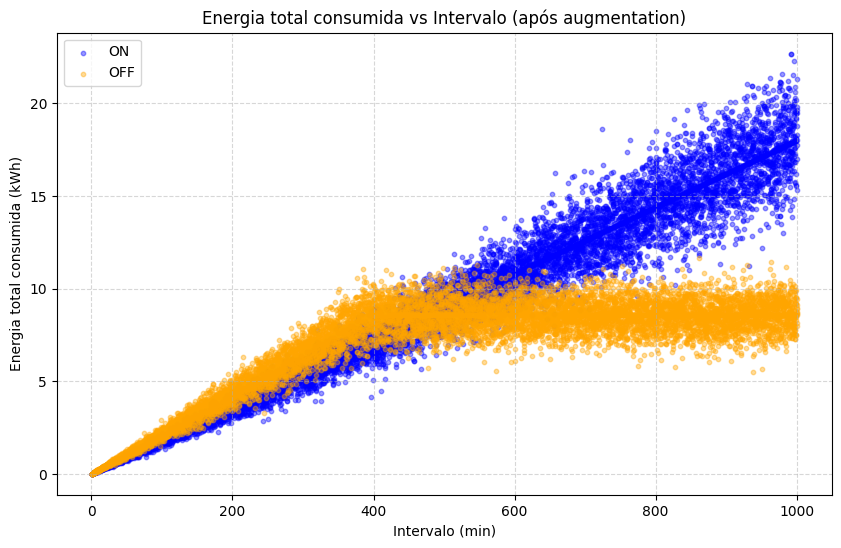

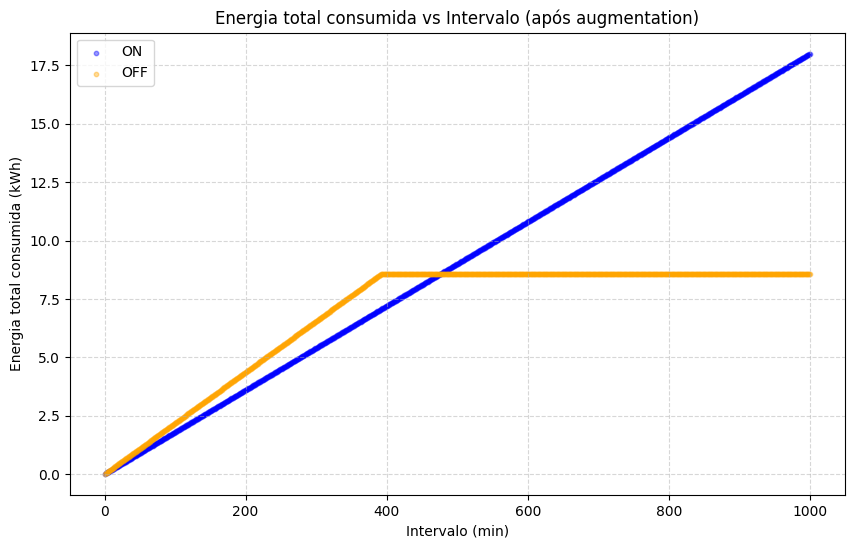

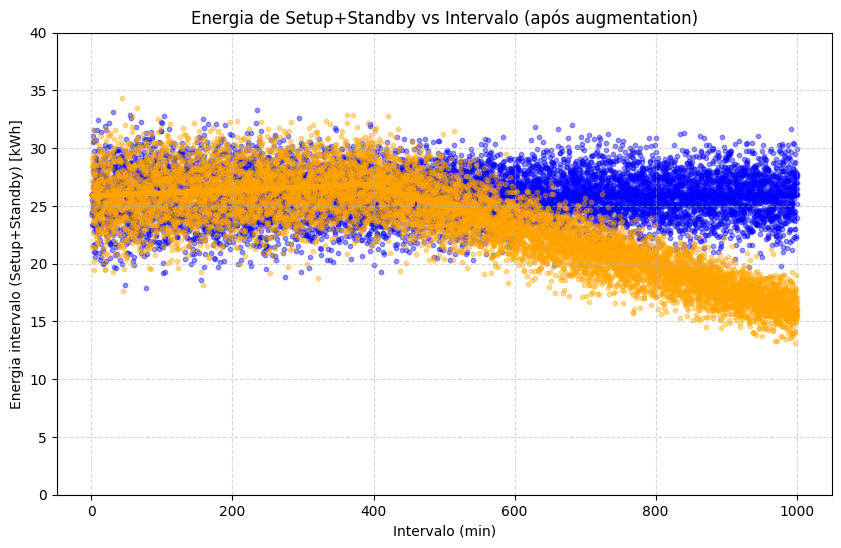

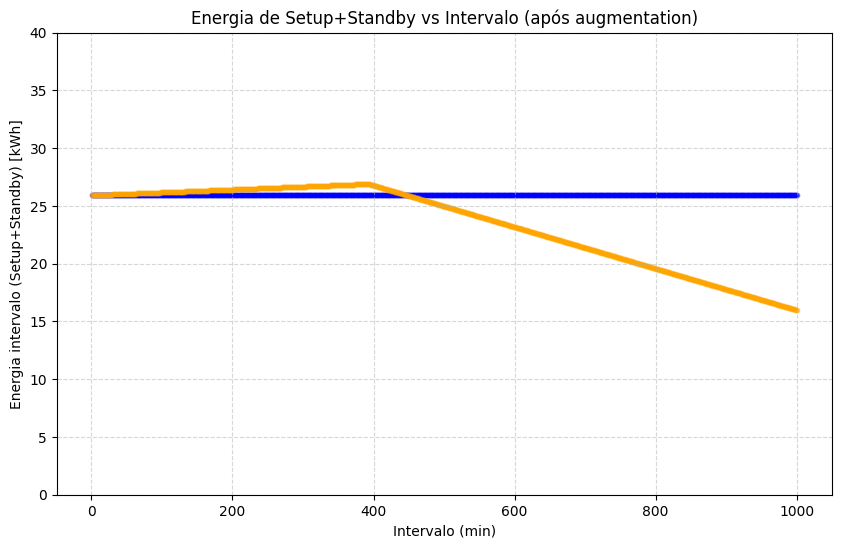

In [ ]:
import matplotlib.pyplot as plt

# Criar coluna de energia no intervalo (setup + standby)
df_aug["Energia_intervalo"] = (
    df_aug["Energia Setup Consumida"] + df_aug["Energia Standby Consumida"]
)
df_aug["Intervalo_min"] = df_aug["Intervalo"] / 60.0
df_origin["Intervalo_min"] = df_origin["Intervalo"] / 60.0

# ======= Gráfico 1: DATA AUGMENTATION: Energia gasta por tempo de intervalo onde intervalo é crescente =======
plt.figure(figsize=(10,6))
for state, color, label in [(0,"blue","ON"), (1,"orange","OFF")]:
    subset = df_aug[df_aug["state"]==state]
    plt.scatter(subset["Intervalo_min"], subset["Energia_intervalo"],
                s=10, alpha=0.4, c=color, label=label)

plt.xlabel("Intervalo (min)")
plt.ylabel("Energia total consumida (kWh)")
plt.title("Energia total consumida vs Intervalo (após augmentation)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ======= Gráfico 1.1: DATA ORIGIN: Energia gasta por tempo de intervalo onde intervalo é crescente =======
plt.figure(figsize=(10,6))
for state, color, label in [(0,"blue","ON"), (1,"orange","OFF")]:
    subset = df_origin[df_origin["state"]==state]
    plt.scatter(subset["Intervalo_min"], subset["Energia_intervalo"],
                s=10, alpha=0.4, c=color, label=label)

plt.xlabel("Intervalo (min)")
plt.ylabel("Energia total consumida (kWh)")
plt.title("Energia total consumida vs Intervalo (após augmentation)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ======= Gráfico 2: Energia no intervalo (setup+standby) =======
plt.figure(figsize=(10,6))
for state, color, label in [(0,"blue","ON"), (1,"orange","OFF")]:
    subset = df_aug[df_aug["state"]==state]
    plt.scatter(subset["Intervalo_min"], subset["E_total_kWh"],
                s=10, alpha=0.4, c=color, label=label)
plt.xlabel("Intervalo (min)")
plt.ylabel("Energia intervalo (Setup+Standby) [kWh]")
plt.title("Energia de Setup+Standby vs Intervalo (após augmentation)")
plt.grid(True, linestyle="--", alpha=0.5)

# Limite do eixo Y
plt.ylim(0,40)

plt.show()

# ======= Gráfico 2.2: Energia no intervalo (setup+standby) Origin =======
plt.figure(figsize=(10,6))
for state, color, label in [(0,"blue","ON"), (1,"orange","OFF")]:
    subset = df_origin[df_origin["state"]==state]
    plt.scatter(subset["Intervalo_min"], subset["E_total_kWh"],
                s=10, alpha=0.4, c=color, label=label)
plt.xlabel("Intervalo (min)")
plt.ylabel("Energia intervalo (Setup+Standby) [kWh]")
plt.title("Energia de Setup+Standby vs Intervalo (após augmentation)")
plt.grid(True, linestyle="--", alpha=0.5)

# Limite do eixo Y
plt.ylim(0,40)


plt.show()


## MLP - Treinamento Neural Network - Energia Total

### Treinamento da Neural Network utilizando a base com data augmentation e diversos hiperparametros para encontrar os melhores hiperparâmetros que resulta no melhor R² evitando overfitting e underfitting

In [ ]:
# ========= BLOCO 1 – hiperparâmetros =========
GRID_HIDDEN = [(32,16), (64,32), (128,64,32)]
GRID_ACT    = ["tanh","relu"]
GRID_ALPHA  = [1e-4, 1e-5]
GRID_LR     = [1e-3, 5e-4]
GRID_ITER   = [2000, 4000]

def treinar_mlp(X, y, hidden, act, alpha, lr, mi):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.neural_network import MLPRegressor
    from sklearn.compose import TransformedTargetRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    Xtr,Xva,ytr,yva = train_test_split(X,y,test_size=0.2,random_state=42)
    mlp = MLPRegressor(hidden_layer_sizes=hidden,
                       activation=act,
                       alpha=alpha,
                       learning_rate_init=lr,
                       max_iter=mi,
                       random_state=42,
                       early_stopping=True,
                       validation_fraction=0.15)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("reg", TransformedTargetRegressor(
            regressor=mlp,
            transformer=StandardScaler()))
    ])
    pipe.fit(Xtr,ytr)
    yhat = pipe.predict(Xva)
    rmse = np.sqrt(mean_squared_error(yva,yhat))
    r2   = r2_score(yva,yhat)
    return pipe, rmse, r2

# ========= BLOCO 2 – entradas/saídas =========
import pandas as pd


# 2) Criar coluna energia em intervalo
df["energia_intervalo"] = df["Energia Setup Consumida"] + df["Energia Standby Consumida"]

# 3) Definir features (entradas) e target (saída)
X = df[["Intervalo","state"]].values
y = df["E_total_kWh"].values

# 4) Rodar grid
resultados = []
for h in GRID_HIDDEN:
    for act in GRID_ACT:
        for a in GRID_ALPHA:
            for lr in GRID_LR:
                for mi in GRID_ITER:
                    pipe, rmse, r2 = treinar_mlp(X, y, h, act, a, lr, mi)
                    resultados.append({
                        "hidden":h,"act":act,"alpha":a,"lr":lr,"max_iter":mi,
                        "RMSE":rmse,"R2":r2,"pipe":pipe
                    })

res_df = pd.DataFrame(resultados).sort_values(by="RMSE")
print(res_df[["hidden","act","alpha","lr","max_iter","RMSE","R2"]].head())


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Consultar base de treinamento da NN

In [ ]:
res_df

### Treinamento focalizado com hiperparâmetros ótimos encontrados

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# 1) Features e target
# ===============================
# energia_intervalo = setup + standby
df["energia_intervalo"] = df["Energia Setup Consumida"] + df["Energia Standby Consumida"]

X = df[["Intervalo","state"]].values
y = df["E_total_kWh"].values

# ===============================
# 2) Split treino/validação
# ===============================
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# 3) Treinar MLP final
# ===============================
mlp = MLPRegressor(
    hidden_layer_sizes=(128,64,32),
    activation="relu",
    alpha=1e-5,
    learning_rate_init=5e-4,
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", TransformedTargetRegressor(
        regressor=mlp,
        transformer=StandardScaler()))
])

pipe.fit(Xtr, ytr)

# ===============================
# 4) Avaliação
# ===============================
yhat = pipe.predict(Xva)
rmse = np.sqrt(mean_squared_error(yva, yhat))
r2   = r2_score(yva, yhat)

print(f"RMSE energia: {rmse:.4f} kWh | R²: {r2:.4f}")

# ===============================
# 5) Função p/ prever ON/OFF
# ===============================
def prever_consumo(pipe, intervalo_min):
    intervalo_s = intervalo_min * 60.0
    X_on  = np.array([[intervalo_s, 0]])  # ON
    X_off = np.array([[intervalo_s, 1]])  # OFF
    return pipe.predict(X_on)[0], pipe.predict(X_off)[0]

# ===============================
# 6) Encontrar Δt* ótimo
# ===============================
def achar_ponto_otimo(pipe, t_min=1, t_max=1000, step=1):
    t_grid = np.arange(t_min, t_max+step, step)
    E_on  = [prever_consumo(pipe, t)[0] for t in t_grid]
    E_off = [prever_consumo(pipe, t)[1] for t in t_grid]
    diff = np.array(E_on) - np.array(E_off)

    idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]
    if len(idx)==0:
        return None
    i = idx[0]
    t0, t1 = t_grid[i], t_grid[i+1]
    d0, d1 = diff[i], diff[i+1]
    t_star = t0 - d0*(t1-t0)/(d1-d0)  # interpolação linear
    return t_star

t_star = achar_ponto_otimo(pipe, t_min=1, t_max=1000, step=1)
print(f"Δt* ótimo previsto pela NN = {t_star:.2f} min")


###**Condicional decisório state station com base no treinamento**

In [ ]:
import numpy as np

# ===============================
# Escolher melhor modelo do grid
# ===============================
best_idx = res_df["RMSE"].idxmin()
best_pipe = res_df.loc[best_idx, "pipe"]

print("Melhor configuração encontrada:")
print(res_df.loc[best_idx, ["hidden","act","alpha","lr","max_iter","RMSE","R2"]])

# ===============================
# Função de previsão ON/OFF
# ===============================
def prever_consumo(pipe, intervalo_min):
    """
    Retorna a energia prevista (kWh) para um intervalo em minutos
    nos estados ON (0) e OFF (1).
    """
    intervalo_s = intervalo_min * 60.0
    X_on  = np.array([[intervalo_s, 0]])  # state=0 (ON)
    X_off = np.array([[intervalo_s, 1]])  # state=1 (OFF)
    E_on  = pipe.predict(X_on)[0]
    E_off = pipe.predict(X_off)[0]
    return E_on, E_off

# ===============================
# Função para achar Δt*
# ===============================
def achar_ponto_otimo(pipe, t_min=1, t_max=720, step=1):
    """
    Procura o intervalo ótimo (em minutos) em que ON e OFF se cruzam.
    Retorna Δt* em minutos.
    """
    t_grid = np.arange(t_min, t_max+step, step)
    E_on  = [prever_consumo(pipe, t)[0] for t in t_grid]
    E_off = [prever_consumo(pipe, t)[1] for t in t_grid]
    diff = np.array(E_on) - np.array(E_off)

    # detectar troca de sinal (ponto de cruzamento)
    idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]
    if len(idx)==0:
        return None
    i = idx[0]
    t0, t1 = t_grid[i], t_grid[i+1]
    d0, d1 = diff[i], diff[i+1]
    # interpolação linear pra refinar
    t_star = t0 - d0*(t1-t0)/(d1-d0)
    return t_star

# ===============================
# Uso
# ===============================
intervalo_min = 60  # exemplo
E_on, E_off = prever_consumo(best_pipe, intervalo_min)

print(f"\nConsumo previsto para {intervalo_min} min de intervalo:")
print(f"  ON  = {E_on:.3f} kWh")
print(f"  OFF = {E_off:.3f} kWh")
print("Melhor opção:", "ON" if E_on < E_off else "OFF")

# achar o ponto ótimo
t_star = achar_ponto_otimo(best_pipe)
if t_star:
    print(f"\n➡️ Estratégia ótima:")
    print(f"   - Manter máquina ligada até ~ [ {t_star:.1f} minutos | {t_star/60:.1f} horas ]  de intervalo")
    print(f"   - A partir desse ponto, desligar será mais econômico (OFF)")
else:
    print("\n⚠️ Não foi encontrado ponto de cruzamento ON/OFF dentro do range testado")


## MLP - Treinamento Neural Network - 2 outputs [ Energia total; Energia Setup/Standby ]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# 1) Preparar entradas e saídas
# ===============================
df["energia_intervalo"] = df["Energia Setup Consumida"] + df["Energia Standby Consumida"]

X = df[["Intervalo", "state"]].values
y = df[["E_total_kWh", "energia_intervalo"]].values   # duas saídas

# ===============================
# 2) Split treino/validação
# ===============================
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42)

# ===============================
# 3) Definir modelo MLP
# ===============================
mlp = MLPRegressor(
    hidden_layer_sizes=(128,64,32),
    activation="relu",
    alpha=1e-5,
    learning_rate_init=5e-4,
    max_iter=4000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.15
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", TransformedTargetRegressor(
        regressor=mlp,
        transformer=StandardScaler()))   # normaliza também o y (2 saídas)
])

# ===============================
# 4) Treinar modelo
# ===============================
pipe.fit(Xtr, ytr)

# ===============================
# 5) Avaliação
# ===============================
yhat = pipe.predict(Xva)

rmse_total = np.sqrt(mean_squared_error(yva[:,0], yhat[:,0]))
rmse_intervalo = np.sqrt(mean_squared_error(yva[:,1], yhat[:,1]))
r2_total = r2_score(yva[:,0], yhat[:,0])
r2_intervalo = r2_score(yva[:,1], yhat[:,1])

print(f"RMSE energia total: {rmse_total:.3f} kWh | R²: {r2_total:.3f}")
print(f"RMSE energia intervalo: {rmse_intervalo:.3f} kWh | R²: {r2_intervalo:.3f}")


RMSE energia total: 1.819 kWh | R²: 0.693
RMSE energia intervalo: 0.857 kWh | R²: 0.961


In [ ]:
import numpy as np

# ===============================
# Previsão ON/OFF
# ===============================
def prever_consumo_duplo(pipe, intervalo_min):
    intervalo_s = intervalo_min * 60.0
    X_on  = np.array([[intervalo_s, 0]])  # ON
    X_off = np.array([[intervalo_s, 1]])  # OFF

    y_on  = np.array(pipe.predict(X_on)).reshape(-1)   # [E_total, E_intervalo]
    y_off = np.array(pipe.predict(X_off)).reshape(-1)
    return y_on, y_off


# ===============================
# Encontrar Δt* para total e intervalo
# ===============================
def achar_pontos_otimos_duplos(pipe, t_min=1, t_max=1000, step=1):
    """
    Retorna TODOS os Δt* (pontos de cruzamento) para energia total e energia de intervalo.
    """
    t_grid = np.arange(t_min, t_max+step, step)
    E_on_all, E_off_all = [], []

    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t)
        E_on_all.append(y_on)
        E_off_all.append(y_off)

    E_on_all = np.array(E_on_all)
    E_off_all = np.array(E_off_all)

    resultados = {}

    for j, nome in enumerate(["E_total", "E_intervalo"]):
        diff = E_on_all[:, j] - E_off_all[:, j]
        idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]

        pontos = []
        for i in idx:
            t0, t1 = t_grid[i], t_grid[i+1]
            d0, d1 = diff[i], diff[i+1]
            t_star = t0 - d0*(t1-t0)/(d1-d0)  # interpolação linear
            pontos.append(t_star)

        resultados[nome] = pontos if pontos else None

    return resultados



# ===============================
# Exemplo de uso
# ===============================
intervalo_min = 200
y_on, y_off = prever_consumo_duplo(pipe, intervalo_min)

if y_on[0] < y_off[0]:
    print("DEIXAR LIGADA ✅ - Melhor opção de chaveamento para o intervalo")
else:
    print("DEIXAR DESLIGADA 🔴 - Melhor opção de chaveamento para o intervalo")

print("-"*100)

print(f"\nConsumo previsto para {intervalo_min} min de intervalo e 24h de processo:")
print(f"  ON  = {y_on[0]:.3f} kWh (total), {y_on[1]:.3f} kWh (intervalo)")
print(f"  OFF = {y_off[0]:.3f} kWh (total), {y_off[1]:.3f} kWh (intervalo)")

resultados = achar_pontos_otimos_duplos(pipe, t_min=1, t_max=1000, step=1)
print("\nPontos ótimos previstos:")

# Δt* total
if resultados["E_total"]:
    print("  Δt* total      = " + ", ".join([f"{v:.2f} min" for v in resultados["E_total"]]))
else:
    print("  Δt* total      = Nenhum cruzamento encontrado")

# Δt* intervalo
if resultados["E_intervalo"]:
    print("  Δt* intervalo  = " + ", ".join([f"{v:.2f} min" for v in resultados["E_intervalo"]]))
else:
    print("  Δt* intervalo  = Nenhum cruzamento encontrado")

print("-"*100)

# calcular média entre os máximos de cada lista
media_t = (max(resultados["E_total"]) + max(resultados["E_intervalo"])) / 2

print(f"Média dos maiores Δt*: {media_t:.2f} min")




DEIXAR LIGADA ✅ - Melhor opção de chaveamento para o intervalo
----------------------------------------------------------------------------------------------------

Consumo previsto para 200 min de intervalo e 24h de processo:
  ON  = 25.923 kWh (total), 3.674 kWh (intervalo)
  OFF = 26.472 kWh (total), 4.483 kWh (intervalo)

Pontos ótimos previstos:
  Δt* total      = 42.05 min, 438.86 min
  Δt* intervalo  = 479.92 min
----------------------------------------------------------------------------------------------------
Média dos maiores Δt*: 459.39 min


/tmp/ipython-input-3349106296.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0]["E_total_kWh"],
/tmp/ipython-input-3349106296.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1]["E_total_kWh"],


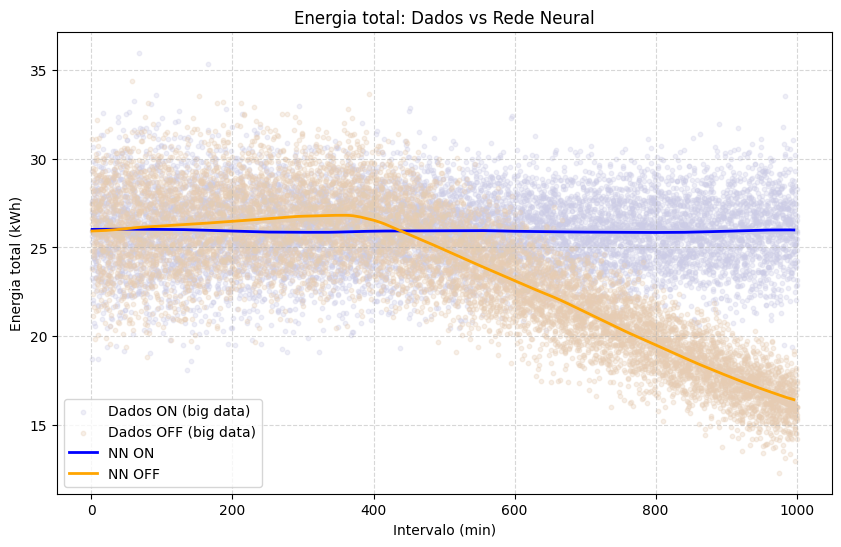

/tmp/ipython-input-3349106296.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0]["energia_intervalo"],
/tmp/ipython-input-3349106296.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1]["energia_intervalo"],


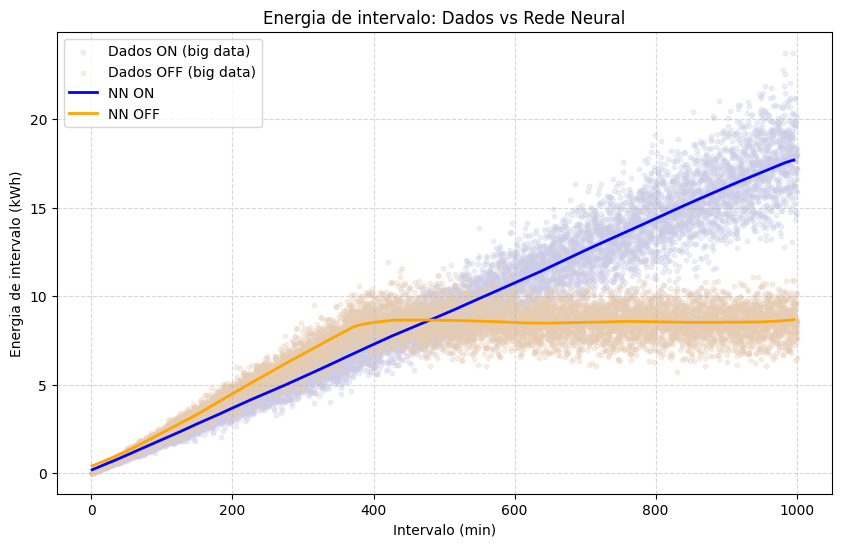

In [ ]:
import matplotlib.pyplot as plt

def plotar_resultado_treinamento(pipe, df, step=5):
    """
    Mostra os pontos reais (big data) e as curvas previstas pela NN
    para energia total e energia de intervalo.
    """
    # Converter tempo para minutos
    df["Intervalo_min"] = df["Intervalo"] / 60.0

    # grade de tempo (min)
    t_grid = np.arange(df["Intervalo_min"].min(), df["Intervalo_min"].max(), step)

    # previsões da NN
    E_on_total, E_off_total = [], []
    E_on_int,   E_off_int   = [], []

    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t)
        E_on_total.append(y_on[0])
        E_off_total.append(y_off[0])
        E_on_int.append(y_on[1])
        E_off_int.append(y_off[1])

    # ===============================
    # Gráfico 1: Energia total
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0]["E_total_kWh"],
                s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)")
    plt.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1]["E_total_kWh"],
                s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)")
    plt.plot(t_grid, E_on_total, c="blue", lw=2, label="NN ON")
    plt.plot(t_grid, E_off_total, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia total (kWh)")
    plt.title("Energia total: Dados vs Rede Neural")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    #plt.ylim(5, 20)

    plt.show()

    # ===============================
    # Gráfico 2: Energia de intervalo
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(df[df["state"]==0]["Intervalo_min"], df[df["state"]==0]["energia_intervalo"],
                s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)")
    plt.scatter(df[df["state"]==1]["Intervalo_min"], df[df["state"]==1]["energia_intervalo"],
                s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)")
    plt.plot(t_grid, E_on_int, c="blue", lw=2, label="NN ON")
    plt.plot(t_grid, E_off_int, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia de intervalo (kWh)")
    plt.title("Energia de intervalo: Dados vs Rede Neural")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plotar_resultado_treinamento(pipe, df, step=5)



# Gráficos de resultados DNN - Modelagem para apresentação no artigo

##Exportar dados de treinamento para controle estático dos resultados (Opção para manipulação da visualização para aplicação dos resultados em pesquisa)

In [ ]:
# export_trained_dnn_and_aug.py
import json, joblib, platform
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import __version__ as sklearn_version

def export_artifacts(
    pipe,
    df_aug: pd.DataFrame,
    feature_cols,            # ex: ["Intervalo", "state"]
    target_cols,             # ex: ["E_total_kWh", "energia_intervalo"]
    outdir="export_mlp",
    noise_sigma=None,        # preencha se tiver usado p/ o ruído gaussiano
    noise_seed=None          # idem
):
    out = Path(outdir); out.mkdir(parents=True, exist_ok=True)

    # 1) Modelo completo (reprodução 1:1 no scikit)
    joblib.dump(pipe, out / "model.joblib", compress=3)

    # 2) Pesos + escalonadores em .npz (portável)
    Xscaler = pipe.named_steps["scaler"]
    ttr     = pipe.named_steps["reg"]                 # TransformedTargetRegressor
    yscaler = ttr.transformer_                        # StandardScaler do y já treinado
    mlp     = ttr.regressor_                          # MLPRegressor treinado

    npz_dict = {
        "X_mean": Xscaler.mean_,
        "X_scale": Xscaler.scale_,
        "y_mean": yscaler.mean_,
        "y_scale": yscaler.scale_,
    }
    # camadas da MLP
    for i, (W, b) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
        npz_dict[f"W{i}"] = W
        npz_dict[f"b{i}"] = b
    np.savez_compressed(out / "weights_and_scalers.npz", **npz_dict)

    # 3) Dataset com augmentation (parquet preserva tipos)
    df_aug.to_parquet(out / "dataset_aug.parquet", index=False)
    # opcional extra em CSV pra abrir em tudo
    df_aug.to_csv(out / "dataset_aug.csv", index=False)

    # 4) Metadados (ordem de colunas, versões, camadas, ruído, etc.)
    meta = {
        "feature_cols": list(feature_cols),
        "target_cols": list(target_cols),
        "python_version": platform.python_version(),
        "sklearn_version": sklearn_version,
        "mlp": {
            "activation": mlp.activation,
            "hidden_layer_sizes": mlp.hidden_layer_sizes,
            "n_layers_": mlp.n_layers_,
            "n_outputs_": mlp.n_outputs_,
        },
        "layers_shapes": [list(W.shape) for W in mlp.coefs_],
        "noise_gaussian": {
            "sigma": noise_sigma,
            "seed": noise_seed
        }
    }
    with open(out / "metadata.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print(f"Export OK em: {out.resolve()}")

# ======== EXEMPLO DE USO ========
# Ajuste conforme suas variáveis:
feature_cols = ["Intervalo", "state"]
target_cols  = ["E_total_kWh", "energia_intervalo"]
export_artifacts(pipe, df_aug, feature_cols, target_cols, outdir="/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation/",
                 noise_sigma=0.05, noise_seed=42)


Export OK em: /content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation


##Ler dados exportados para criação dos gráficos com dados estáticos

/tmp/ipython-input-348263091.py:90: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipython-input-348263091.py:94: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


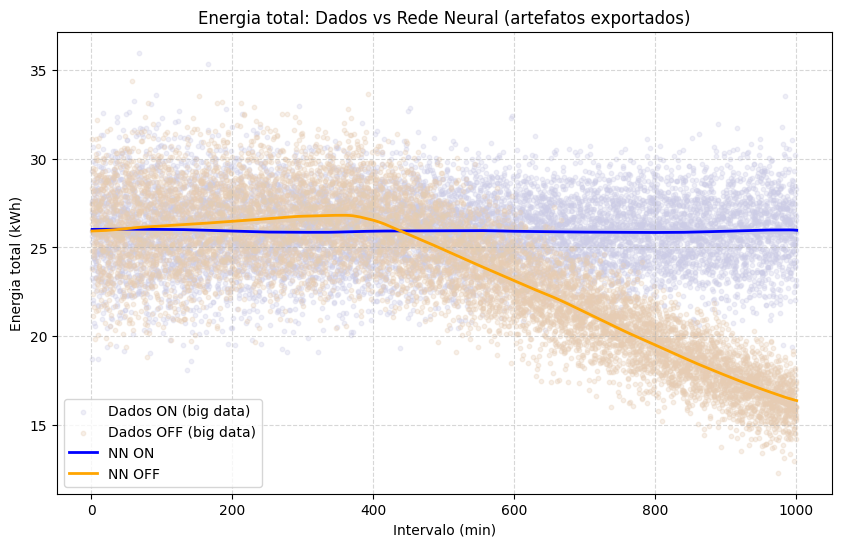

/tmp/ipython-input-348263091.py:111: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipython-input-348263091.py:115: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


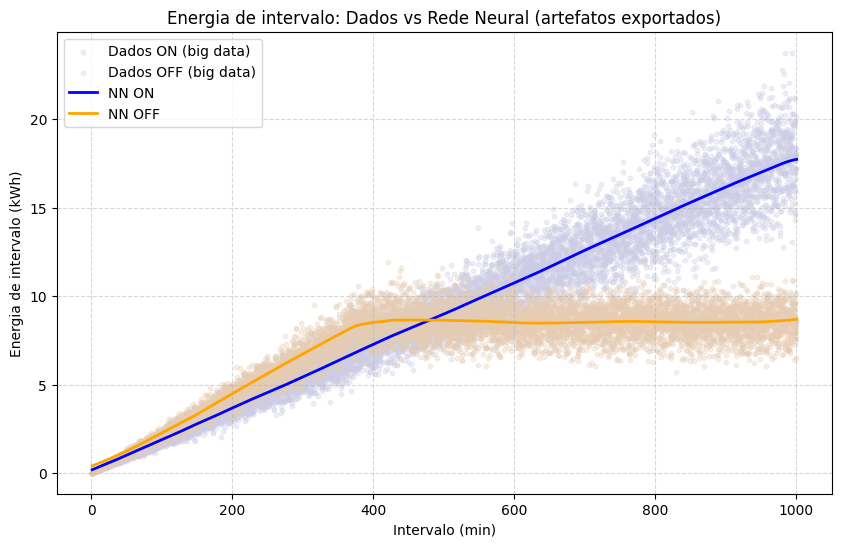

In [ ]:
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === helpers ===
def carregar_artefatos(base_dir):
    base = Path(base_dir)

    # modelo (pipeline completo)
    pipe = joblib.load(base / "model.joblib")

    # metadata (para pegar ordem das colunas etc.)
    meta_path = base / "metadata.json"
    if meta_path.exists():
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)
        feature_cols = meta.get("feature_cols", ["Intervalo", "state"])
        target_cols  = meta.get("target_cols",  ["E_total_kWh", "energia_intervalo"])
    else:
        feature_cols = ["Intervalo", "state"]
        target_cols  = ["E_total_kWh", "energia_intervalo"]

    # dataset (parquet preferível; cai pro csv se não tiver)
    if (base / "dataset_aug.parquet").exists():
        df = pd.read_parquet(base / "dataset_aug.parquet")
    else:
        df = pd.read_csv(base / "dataset_aug.csv")

    return pipe, df, feature_cols, target_cols

def prever_consumo_duplo(pipe, t_min, feature_cols):
    """
    Gera previsão ON (state=0) e OFF (state=1) para um único tempo (em minutos).
    O treino original usou 'Intervalo' em SEGUNDOS, então converto t_min*60.
    """
    t_sec = float(t_min) * 60.0
    # monta DataFrames respeitando a ordem de feature_cols
    linha_on  = {col: 0.0 for col in feature_cols}
    linha_off = {col: 0.0 for col in feature_cols}

    if "Intervalo" not in feature_cols or "state" not in feature_cols:
        raise ValueError(f"As features esperadas ('Intervalo' e 'state') não batem com {feature_cols}")

    linha_on["Intervalo"]  = t_sec
    linha_on["state"]      = 0.0  # ON
    linha_off["Intervalo"] = t_sec
    linha_off["state"]     = 1.0  # OFF

    X_on  = pd.DataFrame([linha_on ], columns=feature_cols).values
    X_off = pd.DataFrame([linha_off], columns=feature_cols).values

    y_on  = pipe.predict(X_on )[0]  # [E_total_kWh, energia_intervalo]
    y_off = pipe.predict(X_off)[0]
    return y_on, y_off

# === função principal (lendo dos arquivos) ===
def plotar_resultado_treinamento_from_exports(base_dir, step=5):
    """
    Lê modelo e dataset exportados e plota:
      - Dispersão dos dados (ON/OFF)
      - Curvas previstas pela NN (ON/OFF)
    step em minutos (resolução da grade)
    """
    pipe, df, feature_cols, target_cols = carregar_artefatos(base_dir)

    # garante a coluna de minutos (dataset usa Intervalo em segundos)
    df = df.copy()
    df["Intervalo_min"] = df["Intervalo"] / 60.0

    # grade de tempo (min)
    t_min = df["Intervalo_min"].min()
    t_max = df["Intervalo_min"].max()
    t_grid = np.arange(t_min, t_max + step, step)

    # previsões
    E_on_total, E_off_total = [], []
    E_on_int,   E_off_int   = [], []

    for t in t_grid:
        y_on, y_off = prever_consumo_duplo(pipe, t, feature_cols)
        E_on_total.append(y_on[0]);  E_off_total.append(y_off[0])
        E_on_int.append(y_on[1]);    E_off_int.append(y_off[1])

    # ===============================
    # Gráfico 1: Energia total
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(
        df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][target_cols[0]],
        s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)"
    )
    plt.scatter(
        df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][target_cols[0]],
        s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)"
    )
    plt.plot(t_grid, E_on_total,  c="blue",   lw=2, label="NN ON")
    plt.plot(t_grid, E_off_total, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia total (kWh)")
    plt.title("Energia total: Dados vs Rede Neural (artefatos exportados)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # ===============================
    # Gráfico 2: Energia de intervalo
    # ===============================
    plt.figure(figsize=(10,6))
    plt.scatter(
        df[df["state"]==0]["Intervalo_min"], df[df["state"]==0][target_cols[1]],
        s=10, alpha=0.3, c=(0.8, 0.8, 0.9, 0.05), label="Dados ON (big data)"
    )
    plt.scatter(
        df[df["state"]==1]["Intervalo_min"], df[df["state"]==1][target_cols[1]],
        s=10, alpha=0.3, c=(0.9, 0.8, 0.7, 0.05), label="Dados OFF (big data)"
    )
    plt.plot(t_grid, E_on_int,  c="blue",   lw=2, label="NN ON")
    plt.plot(t_grid, E_off_int, c="orange", lw=2, label="NN OFF")
    plt.xlabel("Intervalo (min)")
    plt.ylabel("Energia de intervalo (kWh)")
    plt.title("Energia de intervalo: Dados vs Rede Neural (artefatos exportados)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# === uso ===
BASE_DIR = "/content/drive/MyDrive/Mestrado FEI/Aulas/PME 425 - Manufatura Digital e Sistemas Cyber-Fisicos/Artigo Final/Simulações Plant Simulator/Resultados treinamento DNN + Data augmentation"
plotar_resultado_treinamento_from_exports(BASE_DIR, step=5)
